# HK Overall Recycling Rate & G@C Recycling Volume

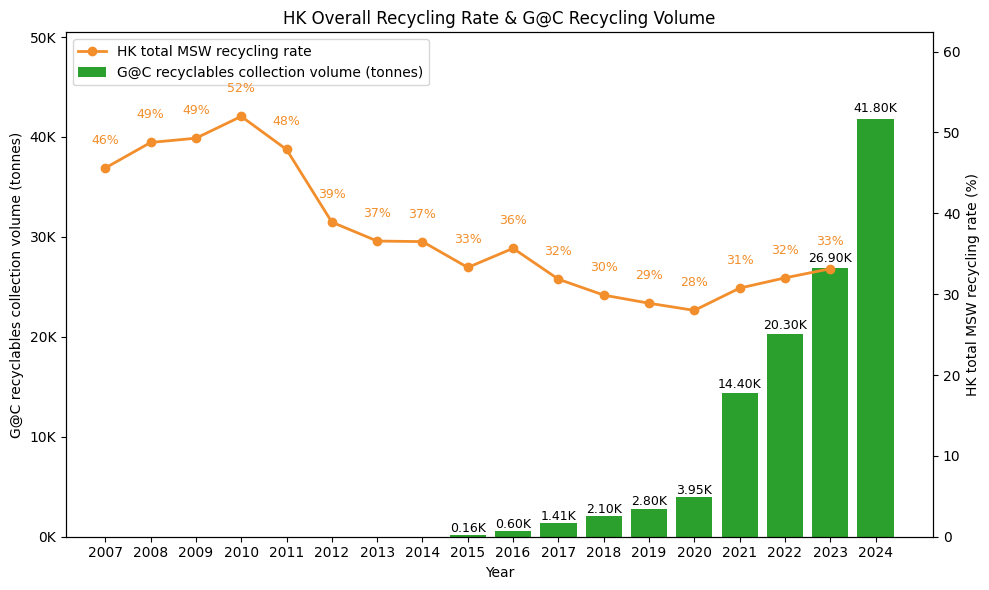

In [4]:
# ==== Install required packages (run these in a terminal, not inside Python) ====
# pip install pandas matplotlib openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import math
import numpy as np

# -------------------------------------------------------
# 1. Load data from the Excel file
# -------------------------------------------------------
excel_path = "../General Stats_G@C_clean.xlsx"

hk = pd.read_excel(
    excel_path,
    sheet_name="HK MSW Volume and Recycling Rat"
)

# -------------------------------------------------------
# 2. Prepare data
# -------------------------------------------------------
col_year = "Year"
col_vol  = "G@C recyclables collection volume (tonnes)"
col_rate = "HK total MSW recycling rate"

# ---- recycling rate (2007–2023) ----
rate_df = hk[[col_year, col_rate]].copy()
rate_df = rate_df[rate_df[col_year].notna() & rate_df[col_rate].notna()].copy()
rate_df["Year_int"] = rate_df[col_year].astype(int)

# clean rate: handles "40%" and 0.40
rate_raw = (
    rate_df[col_rate]
    .astype(str)
    .str.replace("%", "", regex=False)
)
rate_vals = pd.to_numeric(rate_raw, errors="coerce")
mean_rate = rate_vals.dropna().mean()
if mean_rate is not None and mean_rate <= 1:
    rate_vals = rate_vals * 100

rate_df["rate_percent"] = rate_vals

# keep only 2007–2023 for the line
rate_df = rate_df[(rate_df["Year_int"] >= 2007) & (rate_df["Year_int"] <= 2023)]
rate_df = rate_df.sort_values("Year_int")

rate_map = dict(zip(rate_df["Year_int"], rate_df["rate_percent"]))

# ---- recycling volume (2015–2024) ----
vol_df = hk[[col_year, col_vol]].copy()
vol_df = vol_df[vol_df[col_year].notna() & vol_df[col_vol].notna()].copy()
vol_df["Year_int"] = vol_df[col_year].astype(int)
vol_df["vol_tonnes"] = (
    vol_df[col_vol]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(float)
)
vol_df = vol_df.sort_values("Year_int")

vol_map = dict(zip(vol_df["Year_int"], vol_df["vol_tonnes"]))

# ---- combined year range: 2007–2024 ----
all_years = list(range(2007, 2025))  # inclusive of 2024

years   = all_years
rates   = [rate_map.get(y, np.nan) for y in years]      # NaN for 2024
volumes = [vol_map.get(y, np.nan) for y in years]       # NaN for 2007–2014

# -------------------------------------------------------
# 3. Plot: green bars (volume) + orange line (rate)
# -------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

x = range(len(years))

# --- Left axis: G@C recycling volume (bars) ---
bars = ax1.bar(
    x,
    volumes,
    color="#2ca02c",
    label="G@C recyclables collection volume (tonnes)",
)

ax1.set_xlabel("Year")
ax1.set_ylabel("G@C recyclables collection volume (tonnes)")

def k_formatter(val, pos):
    return f"{int(val/1000):,}K"

ax1.yaxis.set_major_formatter(FuncFormatter(k_formatter))

ax1.set_xticks(list(x))
ax1.set_xticklabels([str(y) for y in years], rotation=0)  # no rotation

# bar labels: e.g. 0.16K, 0.60K, 1.41K ...
for xi, bar, vol in zip(x, bars, volumes):
    if math.isnan(vol):
        continue
    vol_k = vol / 1000.0
    label = f"{vol_k:.2f}K"
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() * 1.01,
        label,
        ha="center",
        va="bottom",
        fontsize=9,
        color="black",
    )

# headroom for bar labels
y1_min, y1_max = ax1.get_ylim()
ax1.set_ylim(y1_min, y1_max * 1.15)

# --- Right axis: HK total MSW recycling rate (line, up to 2023 only) ---
ax2 = ax1.twinx()
line_rate, = ax2.plot(
    x,
    rates,                  # 2024 is NaN -> line stops at 2023
    color="#f28e2b",
    marker="o",
    linewidth=2,
    label="HK total MSW recycling rate",
)

ax2.set_ylabel("HK total MSW recycling rate (%)")

rate_max = np.nanmax(rates)
if math.isnan(rate_max) or rate_max <= 0:
    rate_max = 1
ax2.set_ylim(0, rate_max * 1.20)

# rate labels: e.g. 40%, skip NaN (2024)
rate_offset = rate_max * 0.05
for xi, r in zip(x, rates):
    if math.isnan(r):
        continue
    ax2.text(
        xi,
        r + rate_offset,
        f"{r:.0f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#f28e2b",
    )

# -------------------------------------------------------
# 4. Legend, title, layout
# -------------------------------------------------------
handles = [line_rate, bars]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="upper left")

plt.title("HK Overall Recycling Rate & G@C Recycling Volume")
plt.tight_layout()
plt.show()
